# IRM on Bike Sharing hourly dataset

Trying another classic machine learning dateset, the UCI ML repository [Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

For IRM to work, we need to be able to define several _environments_ on which to train. An environment is the result of an intervention - something that changed the data generating process. The environments need to be sufficiently different (and sufficiently similar). Then IRM will return to us an invariant representation - one that has learned the correlations that hold true across environments, but ignored spurious correlations specific to an environment.

In this case, we could try season as the environment. The season may be strongly correlated with bike sharing, but it seems more likely that the effects of the season - the temperature, humidity and wind etc - are actually causal of fewer people biking.

In [111]:
import pandas as pd

import torch

from torch import nn, optim, autograd
from torch.nn import functional as F

Let's work with the hourly data. For now, we'll treat hour as a continuous variable, rather than categorizing it.

In [112]:
df = pd.read_csv('../../data/Bike-Sharing-Dataset/hour.csv')

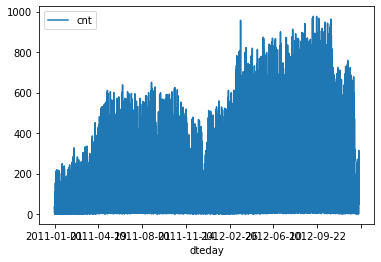

In [113]:
df.plot(x='dteday', y='cnt', kind='line')

In [114]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


A little feature engineering.

In [115]:
day_dummies = pd.get_dummies(df['weekday'])
day_dummies.columns = ['sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat']
day_dummies.head()

,sun,mon,tues,wed,thurs,fri,sat
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [116]:
weather_dummies = pd.get_dummies(df['weathersit'], drop_first=True)
weather_dummies.columns = ['misty', 'rainy','snowy']
weather_dummies.head()

,misty,rainy,snowy
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [117]:
features = [
    'holiday', 'workingday',
    'hr', 'sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat',
    'misty', 'rainy',
    'temp', 'atemp', 'hum', 'windspeed'
]

In [121]:
environment = ['season', 'yr']

In [122]:
target = ['cnt']

In [123]:
df_ = (
    df
    .merge(weather_dummies, left_index=True, right_index=True)
    .merge(day_dummies, left_index=True, right_index=True)
    [features + environment + target]
)

Since during IRM we'll be training on several environments, we wrap each in a dict for easy management.

In [124]:
def construct_env(df):
    return {
        'features': torch.Tensor(
            df.drop(environment + target,
                    axis='columns')
              .to_numpy()
        ),
        'target': torch.Tensor(df['cnt'].to_numpy()).unsqueeze(dim=1)
    }

Define our neural net architecture. We're starting with a straightforward MLP with ReLU nonlinearities and a sigmoid output, since it's a classification problem.

In [327]:
class NN(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_features, hidden_dim)
#        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
 #       x = F.relu(self.layer2(x))
        x = self.layer3(x) # we can't have negative numbers of rentals
        return x

Define a bunch of utility functions for calculating errors and such to report during training.

In [328]:
mse = nn.MSELoss(reduction='mean')

In [329]:
def penalty(predictions, targets):
    dummy = torch.tensor(1., requires_grad=True)
    loss = mse(predictions*dummy, targets)
    grad = autograd.grad(loss, [dummy], create_graph=True)[0]
    squared_grad_norm = (grad**2).sum()
    return squared_grad_norm

Construct environments. We'll take seasons to be the environments. 1 - winter, 2 - spring, 3 - summer, 4 - fall.

To start a new training procedure, we need to run all the code below here, since the environments are mutable dictionaries that pick up entries during training.

In [336]:
env_test = construct_env(df_[(df_.season == 1) & (df_.yr == 0)])
env_valid = construct_env(df_[(df_.season == 4) & (df_.yr == 0)])
env_1 = construct_env(df_[(df_.season == 2) & (df_.yr == 0)])
env_2 = construct_env(df_[(df_.season == 3) & (df_.yr == 0)])

In [337]:
len(env_test['target']), len(env_valid['target']), len(env_1['target']), len(env_2['target'])

(2068, 2134, 2203, 2240)

In [338]:
N_FEATURES = env_1['features'].shape[1]
HIDDEN_DIM = 50

In [339]:
net = NN(N_FEATURES, HIDDEN_DIM)

In [340]:
opt = optim.Adam(net.parameters(), lr=1e-3)

In [341]:
for iteration in range(10001):
    for env in [env_1, env_2]:
        preds = net(env['features'])
        env['error'] = mse(preds, env['target'])
        env['penalty'] = penalty(preds, env['target'])
    
    train_error = torch.stack([env_1['error'], env_2['error']]).mean()
    train_penalty = torch.stack([env_1['penalty'], env_2['penalty']]).mean()
    
    # deactivate IRM to begin
    
#     total_loss = train_error

    # delayed introduction of IRM penalty (or hard to start learning)
    if iteration < 2000:
        total_loss = train_error + train_penalty
    else:
        total_loss = (train_error + 1e5 * train_penalty)
    
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    
    valid_preds = net(env_valid['features'])
    env_1_preds = net(env_1['features'])
    env_2_preds = net(env_2['features'])
    
    # ## train environment metrics
    env_1['mse'] = mse(env_1_preds, env_1['target'])
    env_2['mse'] = mse(env_2_preds, env_2['target'])
    
    # ## validation set metrics
    env_valid['mse'] = mse(valid_preds, env_valid['target'])
    
    if iteration % 1000 == 0:
        print('---')
        print('iteration: {}, train_loss: {:.8f}'.format(iteration, total_loss))
        print('env_1 mse: {:.3f}'.format(env_1['mse']))
        print('env_2 mse: {:.3f}'.format(env_2['mse']))
        print('env_valid mse: {:.3f}'.format(env_valid['mse']))
        print('train penalty: {:.3f}'.format(train_penalty))

---
iteration: 0, train_loss: 61565.75390625
env_1 mse: 44073.273
env_2 mse: 57474.250
env_valid mse: 41156.359
train penalty: 10762.047
---
iteration: 1000, train_loss: 50700.26953125
env_1 mse: 44006.637
env_2 mse: 57393.371
env_valid mse: 41093.844
train penalty: 0.264
---
iteration: 2000, train_loss: 75836.06250000
env_1 mse: 44086.582
env_2 mse: 57488.555
env_valid mse: 41169.602
train penalty: 0.251
---
iteration: 3000, train_loss: 50736.80078125
env_1 mse: 44007.207
env_2 mse: 57393.812
env_valid mse: 41094.844
train penalty: 0.000
---
iteration: 4000, train_loss: 50700.52734375
env_1 mse: 44007.230
env_2 mse: 57393.801
env_valid mse: 41094.883
train penalty: 0.000
---
iteration: 5000, train_loss: 50700.51562500
env_1 mse: 44007.230
env_2 mse: 57393.801
env_valid mse: 41094.883
train penalty: 0.000
---
iteration: 6000, train_loss: 50700.51562500
env_1 mse: 44007.230
env_2 mse: 57393.801
env_valid mse: 41094.883
train penalty: 0.000
---
iteration: 7000, train_loss: 50700.51562500

KeyboardInterrupt: 

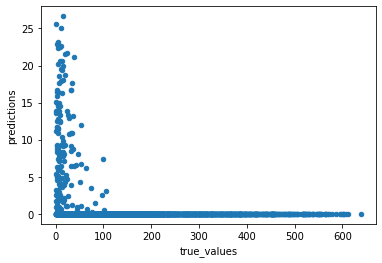

In [326]:
(
    pd.DataFrame({
        'predictions': net(env_1['features']).squeeze().tolist(),
        'true_values': env_1['target'].squeeze().tolist()
    }).plot(x='true_values', y='predictions', kind='scatter')
)

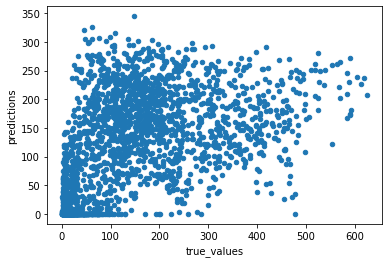

In [302]:
(
    pd.DataFrame({
        'predictions': net(env_valid['features']).squeeze().tolist(),
        'true_values': env_valid['target'].squeeze().tolist()
    }).plot(x='true_values', y='predictions', kind='scatter')
)

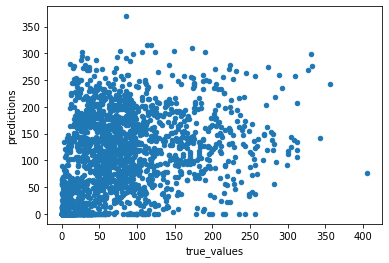

In [303]:
(
    pd.DataFrame({
        'predictions': net(env_test['features']).squeeze().tolist(),
        'true_values': env_test['target'].squeeze().tolist()
    }).plot(x='true_values', y='predictions', kind='scatter')
)

In [191]:
mse(net(env_test['features']), env_test['target']).item()

3295.386474609375

In [81]:
total_loss, train_error, train_penalty

(tensor(86832.2344, grad_fn=<MeanBackward0>),
 tensor(86832.2344, grad_fn=<MeanBackward0>),
 tensor(0., grad_fn=<MeanBackward0>))

In [98]:
env_1['mse']

tensor(16716.8301, grad_fn=<MseLossBackward>)

In [100]:
mse(net(env_test['features']), env_test['target']).item()

14882.7744140625

In [110]:
mse(net(env_test['features']), env_test['target']).item()

7185.4326171875